In [1]:
import os
import sys

import scipy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import pandas as pd
import matplotlib.pyplot as plt

os.environ["CUBLAS_WORKSPACE_CONFIG"]=":4096:8"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

np.random.seed(42)
C0 = '#005AFF'
C1 = '#FF4B00'

if "../scripts" not in sys.path:
    sys.path.append("../scripts")
    
plt.rcParams["font.size"] = 18
%matplotlib inline
%config InlineBackend.figure_formats = ['png']
%load_ext autoreload
%autoreload 2

# Loss ablation study with Simple Limit Cycle
This notebook evaluates the effect of the each loss term, `rec`, `rec_diff`, `dec`, `dec_diff`, `lat`, `enc`.
The each loss term is removed one by one for each train trial.
We compare the RMSE for loss ablation.

In [2]:
from scipy.integrate import solve_ivp
dim_x = 2
alpha = 1.
omega = 2.0
mu = 1e0
epoch = 500
N = 100
T = 2 * np.pi / omega * 0.5
delta_t = T / N
data = np.empty((epoch, N, dim_x))
times = np.empty((epoch, N, 1))

def exponential_decay(t, y):
    y0 = alpha * y[0] - omega * y[1] - y[0] * (y[0] ** 2 + y[1] ** 2)
    y1 = omega * y[0] + alpha * y[1] - y[1] * (y[0] ** 2 + y[1] ** 2)
    # y0 = - omega * y[1]
    # y1 = omega * y[0]
    return np.asarray([y0, y1])

for i in range(epoch):
    r = np.random.randn() * 2.0 + np.sqrt(alpha)
    th = np.random.uniform(-np.pi, np.pi)
    x0 = np.array([r * np.cos(th), r * np.sin(th)])  

    t = np.arange(N) * delta_t
    sol = solve_ivp(exponential_decay, [0, T], y0=x0, t_eval=t)
    data[i] = sol.y.T
    times[i] = sol.t.reshape(-1, 1)

# Learning

In [3]:
trajectory = torch.tensor(data, dtype=torch.float32, device="cuda")
trajectory = trajectory.cuda()
dt = np.diff(times, axis=1).mean()

print("traj.shape", trajectory.shape, "dt", dt)

traj.shape torch.Size([500, 100, 2]) dt 0.015707963267948963


In [7]:
from phase_amplitude_reduction import PADynTrainer
from joblib import Parallel, delayed
from math import sqrt

def trainer_loss_ablation_learning(exp_name, keys, trajectory, dt=dt):
    enable_loss = {"recon": True, "rec_diff": True, "dec": True, "dec_diff": True, "enc": True, "lat": True}
    for key in keys:
        enable_loss[key] = False

    dim_obs = trajectory.shape[-1]
    recon_loss_coef = torch.ones(dim_obs, dtype=trajectory.dtype, device=trajectory.device) * 1.0
    beta = alpha * 2

    for ep_i in range(5):
        trainer = PADynTrainer(
            dim_latent=2,
            dim_obs=dim_obs,
            hidden_layer_size=[512, 512],
            delta_t=dt,
            device="cuda",
            num_iters=5000,
            learning_rate=1e-3,
            discount_gamma=0.99,  # 0.99 ** 50 ~ 0.6
            latent_noise=1e-5,
            natural_freq=omega / (2 * np.pi),
            amplitude_range=[beta, beta],
            recon_loss_coef=recon_loss_coef,
            enable_loss=enable_loss,
        )

        trainer.learn(trajectory[:trajectory.shape[0]  // 2, :trajectory.shape[1]])
        trainer.save(f"../data/loss_ablation_{exp_name}_{ep_i}.pt")
    print(exp_name, enable_loss)
    return None

keys_dict = {
    "Base": [],
    "rm_q1": ["recon", "rec_diff", "lat"],
    "rm_q2": ["dec", "dec_diff", "enc"],
    "rm_p1p3": ["recon", "rec_diff", "dec", "dec_diff"],
    "rm_p2p4": ["enc", "lat"],
    "rm_diff": ["rec_diff", "dec_diff"],
    "rm_recon": ["recon", "rec_diff"],
    "rm_dec": ["dec", "dec_diff"],
    "rm_lat": ["lat"],
    "rm_enc": ["enc"],
    }
# out = Parallel(n_jobs=6)(delayed(trainer_loss_ablation_learning)(name, keys, trajectory) for name, keys in keys_dict.items())

## RMSE evaluation for each model

In [13]:
rmse_result = {"exp_name": [], "RMSE": [], "experiment_id": []}
exp_name_list = keys_dict.keys()
for name in exp_name_list:
    for ep_i in range(5):
        print(ep_i)
        model = PADynTrainer.load(f"../data/loss_ablation_{name}_{ep_i}.pt")
        model.to("cuda")
        trainer =  model

        T = data.shape[1]
        traj = torch.tensor(data, dtype=torch.float32, device="cuda")
        obs_pred, latent = trainer.rollout(traj[:, 0:1], T, predict=True)
        latent = latent.detach().cpu()
        obs_pred = obs_pred.detach().cpu().numpy()
        num_data = data.shape[0]
        norm = np.square(obs_pred[num_data // 2:] - data[num_data // 2:]).sum(axis=2)
        RMSE = np.sqrt(norm.mean(axis=1)).mean(axis=0)
        print(f"RMSE:{RMSE:.5f}")

        rmse_result["exp_name"].append(str(name))
        rmse_result["RMSE"].append(RMSE)
        rmse_result["experiment_id"].append(ep_i)
    

0
RMSE:0.04480
1
RMSE:0.04728
2
RMSE:0.04602
3
RMSE:0.05064
4
RMSE:0.04815
0
RMSE:0.05468
1
RMSE:0.05965
2
RMSE:0.04951
3
RMSE:0.06278
4
RMSE:0.06160
0
RMSE:0.03896
1
RMSE:0.04833
2
RMSE:0.04194
3
RMSE:0.04360
4
RMSE:0.03855
0
RMSE:0.04755
1
RMSE:0.04620
2
RMSE:0.05324
3
RMSE:0.04897
4
RMSE:0.05268
0
RMSE:0.08294
1
RMSE:0.08557
2
RMSE:0.08358
3
RMSE:0.07036
4
RMSE:0.09345
0
RMSE:0.06502
1
RMSE:0.05551
2
RMSE:0.06454
3
RMSE:0.06810
4
RMSE:0.06826
0
RMSE:0.06525
1
RMSE:0.05890
2
RMSE:0.05511
3
RMSE:0.05177
4
RMSE:0.05091
0
RMSE:0.04699
1
RMSE:0.04194
2
RMSE:0.04507
3
RMSE:0.04648
4
RMSE:0.05521
0
RMSE:0.05697
1
RMSE:0.04393
2
RMSE:0.04317
3
RMSE:0.05642
4
RMSE:0.06122
0
RMSE:0.04750
1
RMSE:0.04422
2
RMSE:0.03944
3
RMSE:0.05050
4
RMSE:0.04702


# Loss Ablation Study with RMSE

/tmp/ipykernel_879855/3071291477.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(rmse_result, x="exp_name", y="RMSE", palette=palette, order=order_list)
/tmp/ipykernel_879855/3071291477.py:6: UserWarning: 
The palette list has fewer values (9) than needed (50) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(rmse_result, x="exp_name", y="RMSE", palette=palette, order=order_list)
/tmp/ipykernel_879855/3071291477.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(rmse_result, x="exp_name", y="RMSE", palette=palette, order=order_list, edgecolor="black", linewidth=1)
/tmp/ipykernel_879855/3071291477.py:7: UserWarning: 
The palette list has fewer values (9) than n

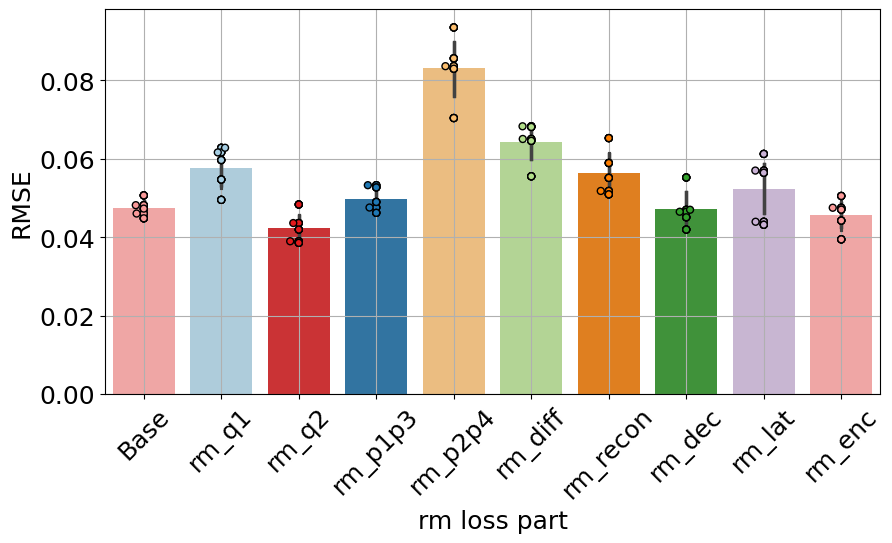

In [28]:
plt.figure(figsize=(10, 5))

order_list = rmse_result["exp_name"]

palette = sns.color_palette("Paired", n_colors=9)
sns.barplot(rmse_result, x="exp_name", y="RMSE", palette=palette, order=order_list)
sns.swarmplot(rmse_result, x="exp_name", y="RMSE", palette=palette, order=order_list, edgecolor="black", linewidth=1)
# plt.title("Loss Ablation Study")
plt.xlabel("rm loss part")
plt.ylabel("RMSE")
plt.grid()
plt.xticks(rotation=45)
plt.ylim(0, None)
plt.show()

/tmp/ipykernel_879855/1039072903.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(rmse_result, x="exp_name", y="RMSE", palette=palette, order=order_list)
/tmp/ipykernel_879855/1039072903.py:6: UserWarning: The palette list has more values (9) than needed (8), which may not be intended.
  sns.barplot(rmse_result, x="exp_name", y="RMSE", palette=palette, order=order_list)
/tmp/ipykernel_879855/1039072903.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(rmse_result, x="exp_name", y="RMSE", palette=palette, order=order_list, edgecolor="black", linewidth=1)
/tmp/ipykernel_879855/1039072903.py:7: UserWarning: The palette list has more values (9) than needed (8), which may not be intended

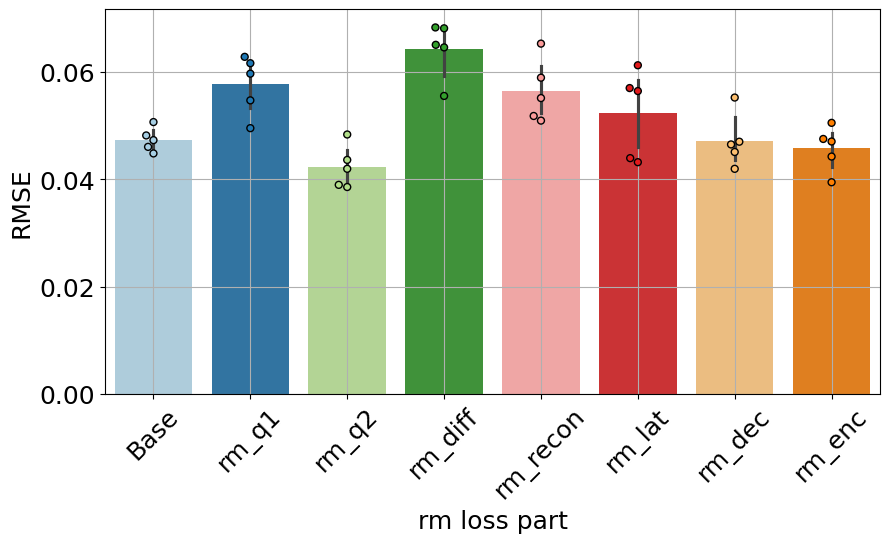

In [32]:
plt.figure(figsize=(10, 5))

order_list = ["Base", "rm_q1", "rm_q2", "rm_diff", "rm_recon", "rm_lat", "rm_dec", "rm_enc"]

palette = sns.color_palette("Paired", n_colors=9)
sns.barplot(rmse_result, x="exp_name", y="RMSE", palette=palette, order=order_list)
sns.swarmplot(rmse_result, x="exp_name", y="RMSE", palette=palette, order=order_list, edgecolor="black", linewidth=1)
# plt.title("Loss Ablation Study")
plt.xlabel("rm loss part")
plt.ylabel("RMSE")
plt.grid()
plt.xticks(rotation=45)
plt.ylim(0, None)
plt.savefig("../data/loss_ablation_study.svg", bbox_inches="tight", dpi=300)
plt.show()